In [1]:
from __future__ import print_function, division
import sys,os
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.basis import spinless_fermion_basis_1d # fermion basis for comparison
import numpy as np # generic math functions
import matplotlib.pyplot as plt
from itertools import chain, combinations
plt.rcParams['figure.figsize'] = [10, 8] # changes default figure size in jupyter notebook

 ## Coupling & Option initialization

In [20]:
NN = 2 #Z_NN model
N=12 # number of sites (NOT STAGGERED SITES!!)
Pinit=1 # P_{-1}
g = 1 # E-field coupling constant
t = -.5 # coupling constant for hopping term
m = 1 # mass

half_filling = 1 # options: 1 for half filling, 0 for not half-filling
single_filling = 0 # options: 1 for single-filling, 0 else

PBC = 1 # options: 1 for periodic boundary conditions, 0 for fixed

if(N % 4 < 2): # Checks if N is even for anti- or periodic boundary conditions
    Neven = 1
else:
    Neven = 0

In [21]:
def arrayn(n): ## returns an array of length n with values 0,...,n-1
    return([i for i in range(n)])

if(half_filling): # sets filling to N//2 if half filling is turned on, else it does not specify
    basis = spin_basis_1d(N,pauli=-1,Nup=N//2)
elif(single_filling):
    basis = spin_basis_1d(N,pauli=-1,Nup=1)
else:
    basis = spin_basis_1d(N,pauli=-1)
    
def powerset(seq): #used in the powerarray function below for creating powersets
    if len(seq) == 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item
            
def powerarray(array): #makes an array containing the powerset of the array taken as input
    return [i for i in powerset(array)]

In [22]:
###### Hopping terms
if(PBC):
    
    if(Neven): # Anti-Periodic
        J2 = [[-t,i,(i+1)%N] for i in range(N-1)] # The final boundary term must be added with negative coupling
        J3 = [[-t,(i+1)%N,i] for i in range(N-1)] 
        J2.append([t,N-1,0]) # The negatively-coupled (anti-periodic) final boundary terms
        J3.append([t,0,N-1])
    
    else: # Periodic 
        J2 = [[-t,i,(i+1)%N] for i in range(N)] # %N and range increased by 1 adds the final boundary term making it periodic
        J3=[[-t,(i+1)%N,i] for i in range(N)]
    
else: # Fixed boundary conditions
    J2 = [[-t,i,i+1] for i in range(N-1)] # we need to append "+-" for signs of sigmas
    J3=[[-t,i+1,i] for i in range(N-1)] # append "+-" for signs of sigmas, i+1,i since this is h.c. term

###### mass term (unchanged by PBC)
J4 = [[m*(-1.0)**i,i,i] for i in range(N)] # append  "+-" for signs of sigmas

In [23]:
staticpart=[["+-",J4],["+-",J2],["+-",J3]] # Defining static and dynamic parts of H and filling with hopping and mass terms
dynamicpart=[]

In [24]:
###### E-field interaction term

zstring = "z"
def upperindices(n): # Creating a function to make the right length string of "z"
    a = ""
    for i in range(n):
        a = a + zstring
    return(a)

def summandJ1(indices,n): # Creating a function to generate coupling lists for the E-field product term
    #n is the site to which we have summed so far in the outermost sum,
    #indices is an array of lower indices for sigma_n^z matrices which are interacting in this particular term of the expanded product
    
    coupling = -Pinit*g*(-1.0)**(n*(n+1.0)*.5) #Initial coupling parameters which are independent of indices input
    
    for k in range(n+1):
        coupling = coupling*(np.exp((-1.0**k)*1j*np.pi/NN)) #Exponential product term
        
    coupling = coupling*(np.cos(np.pi/NN))**(n-len(indices)+1)*(-1.0j*np.sin(np.pi/NN))**len(indices) #Cosine & Sine terms
    # This is kinda just the binomial expansion formula
    
    indices.insert(0,coupling) #insert coupling into the list for quspin
    operatorlist=[upperindices(len(indices)-1),[indices]] #insert the string of "z" indicators of proper length
    return(operatorlist) 

for i in range(0,N): # Piecemeal inserting the E-field product term into the hamiltonian
    summandindices = arrayn(i+1) #creates a list of indices 0,i for our current i
    for k in powerarray(summandindices): #every term in this power set corresponds to exactly one term in the expansion of the
                                         #product term, so we take each combination of indices of sigma^z matrices from this powerset
        if(k ==[]): #skip over the empty set
            continue
        else:
            staticpart.insert(0,summandJ1(k,i)) #insert the completed coupling & index list

## Plot

Symmetry checks passed!
Particle conservation check passed!
# of eigenvalues: 924


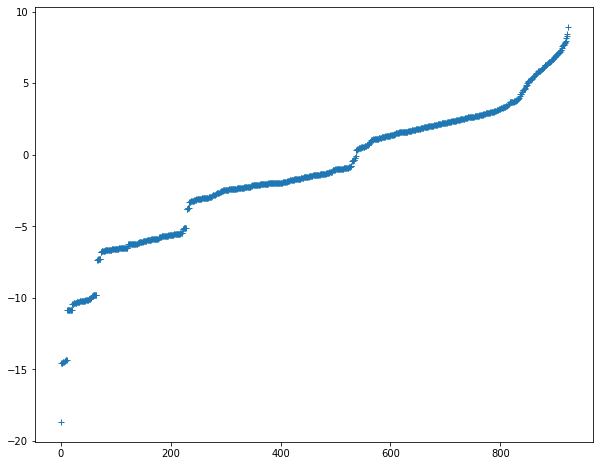

In [25]:
H1 = hamiltonian(staticpart,dynamicpart,basis=basis,dtype=np.complex64,check_herm=False) # Creating the hamiltonian with proper basis

eigenvalues1 = H1.eigvalsh() # Getting and plotting eigenvalues
plt.plot(eigenvalues1,'+')

print("# of eigenvalues: " + str(len(eigenvalues1))) # Printing number of eigenvalues for comparison